# Init

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../infras/')
sys.path.append('../infras/dashboards/')
sys.path.append('../experiments/')
sys.path.append('../experiments/pipeline/')
sys.path.append('../preprocess/intra_variance/')
sys.path.append('../models/cell_proportions/')
sys.path.append('../measures/cell_proportions_measures/')
sys.path.append('../preprocess/cell_specifics/')


In [2]:
from data_factory import DataFactory
from global_utils import GlobalUtils
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
import exploration_cytof_plots as cytof_plots
from basic import BasicDeconv
from pp_entropy_based import PpEntropyBased
from pp_dep_de_based import  PpDepDeBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins
from deconv_py.preprocess.cell_specifics.pp_svm_signature import PpSvmSignature
from deconv_py.preprocess.cell_specifics.pp_entropy_based_totel_sum import PpEntropyBasedTotelSum
from deconv_py.preprocess.cell_specifics.pp_floor_under_quantile import PpFloorUnderQuantile



from pp_keep_specific_cells  import  PpKeepSpecificCells
from pp_agg_to_specific_cells import PpAggToSpecificCells

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader
from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation
from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot
from cellMix_coordinator import CellMixCoordinator

import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import os
import pickle as pkl 
from sklearn.decomposition import PCA
from IPython.display import display, HTML


%connect_info

{
  "shell_port": 63487,
  "iopub_port": 63488,
  "stdin_port": 63489,
  "control_port": 63490,
  "hb_port": 63491,
  "ip": "127.0.0.1",
  "key": "944e2374-88e196bc9872180dde5ef1d2",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9d7e6a87-d7ae-4ab2-87ee-d2616b9b0cf5.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# build data for r script

In [3]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)

B = B_all_vs.copy(deep=True)
B.index = B.index.droplevel(0)

B = B.loc[~B.index.duplicated(keep='first')]
B.to_csv(r"C:\Repos\deconv_py\deconv_py\infras\xCell\B.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


# results 

In [4]:
ccc = CytofCellCountInfra()
cytof_results = ccc.get_cytof_count_per_sample(filter_by_version='')
mapping = {'B-cells':'B cells ',
'CD4+ naive T-cells' : 'Na?ve CD4 Tcell',
'CD4+ Tcm' : 'CD4+central memory Tcells',
'CD4+ Tem' :'CD4+ effector memory T cells' ,
'CD8+ naive T-cells' :'Na?ve CD8 Tcell' ,
'CD8+ Tem' :'CD8+ effector memory T cells' ,
"pDC" :'Plasmacytoid dendritic cells' ,
'Monocytes' : 'Monocytes'     }

In [5]:
results = pd.read_csv("C:/Repos/thirdparty/xCell/xCell/R/xcell_scores.csv").rename(columns = {'Unnamed: 0':"cell"}).set_index("cell")
results = results.rename(columns={col:col.split("X")[1] for col in results.columns})
results = results.loc[mapping.keys()].rename(mapping)
results = (results/results.sum())

In [7]:
# mix_mapping = GlobalUtils.get_corospanding_mixtures_map(cytof_results,results)
# cytof_results = cytof_results.rename(columns=mix_mapping)
# cytof_results = cytof_results[[col for col in mix_mapping.values()]]

# print(results.corrwith(cytof_results,method="pearson").mean())
# cytof_plots.plot_mass_to_cytof_scatter_all_on_one(results,cytof_results,results)
# cytof_plots.plot_mass_to_cytof_scatter_per_cell(results,cytof_results,results)

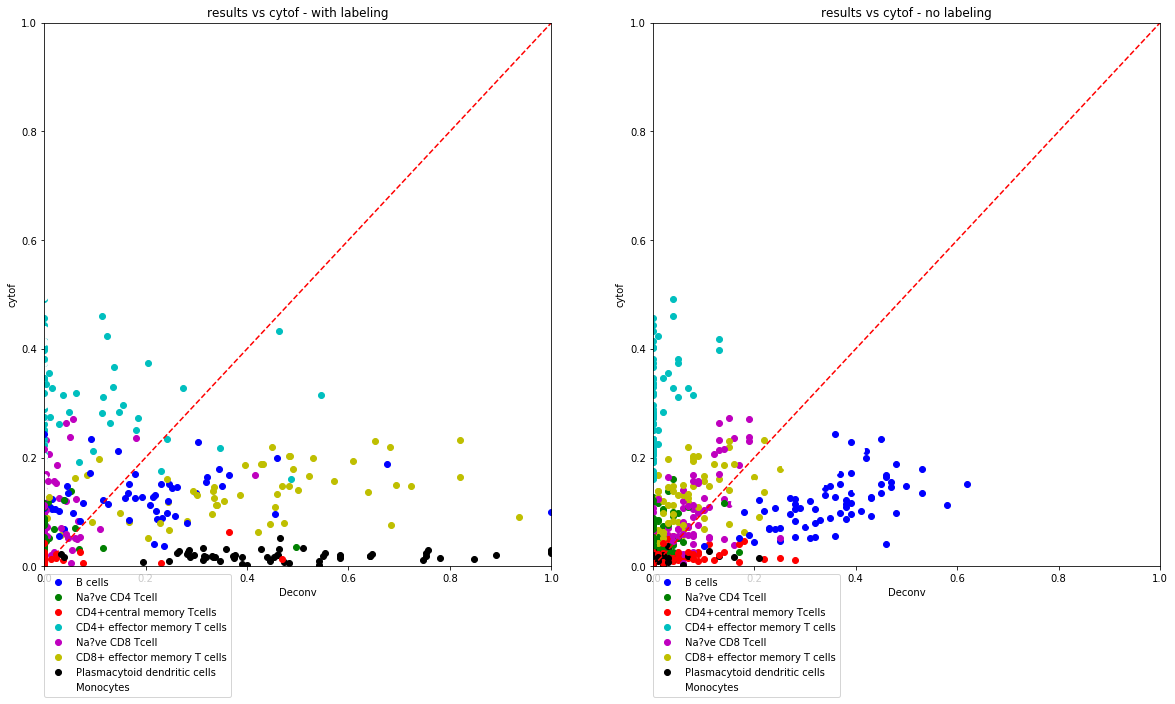

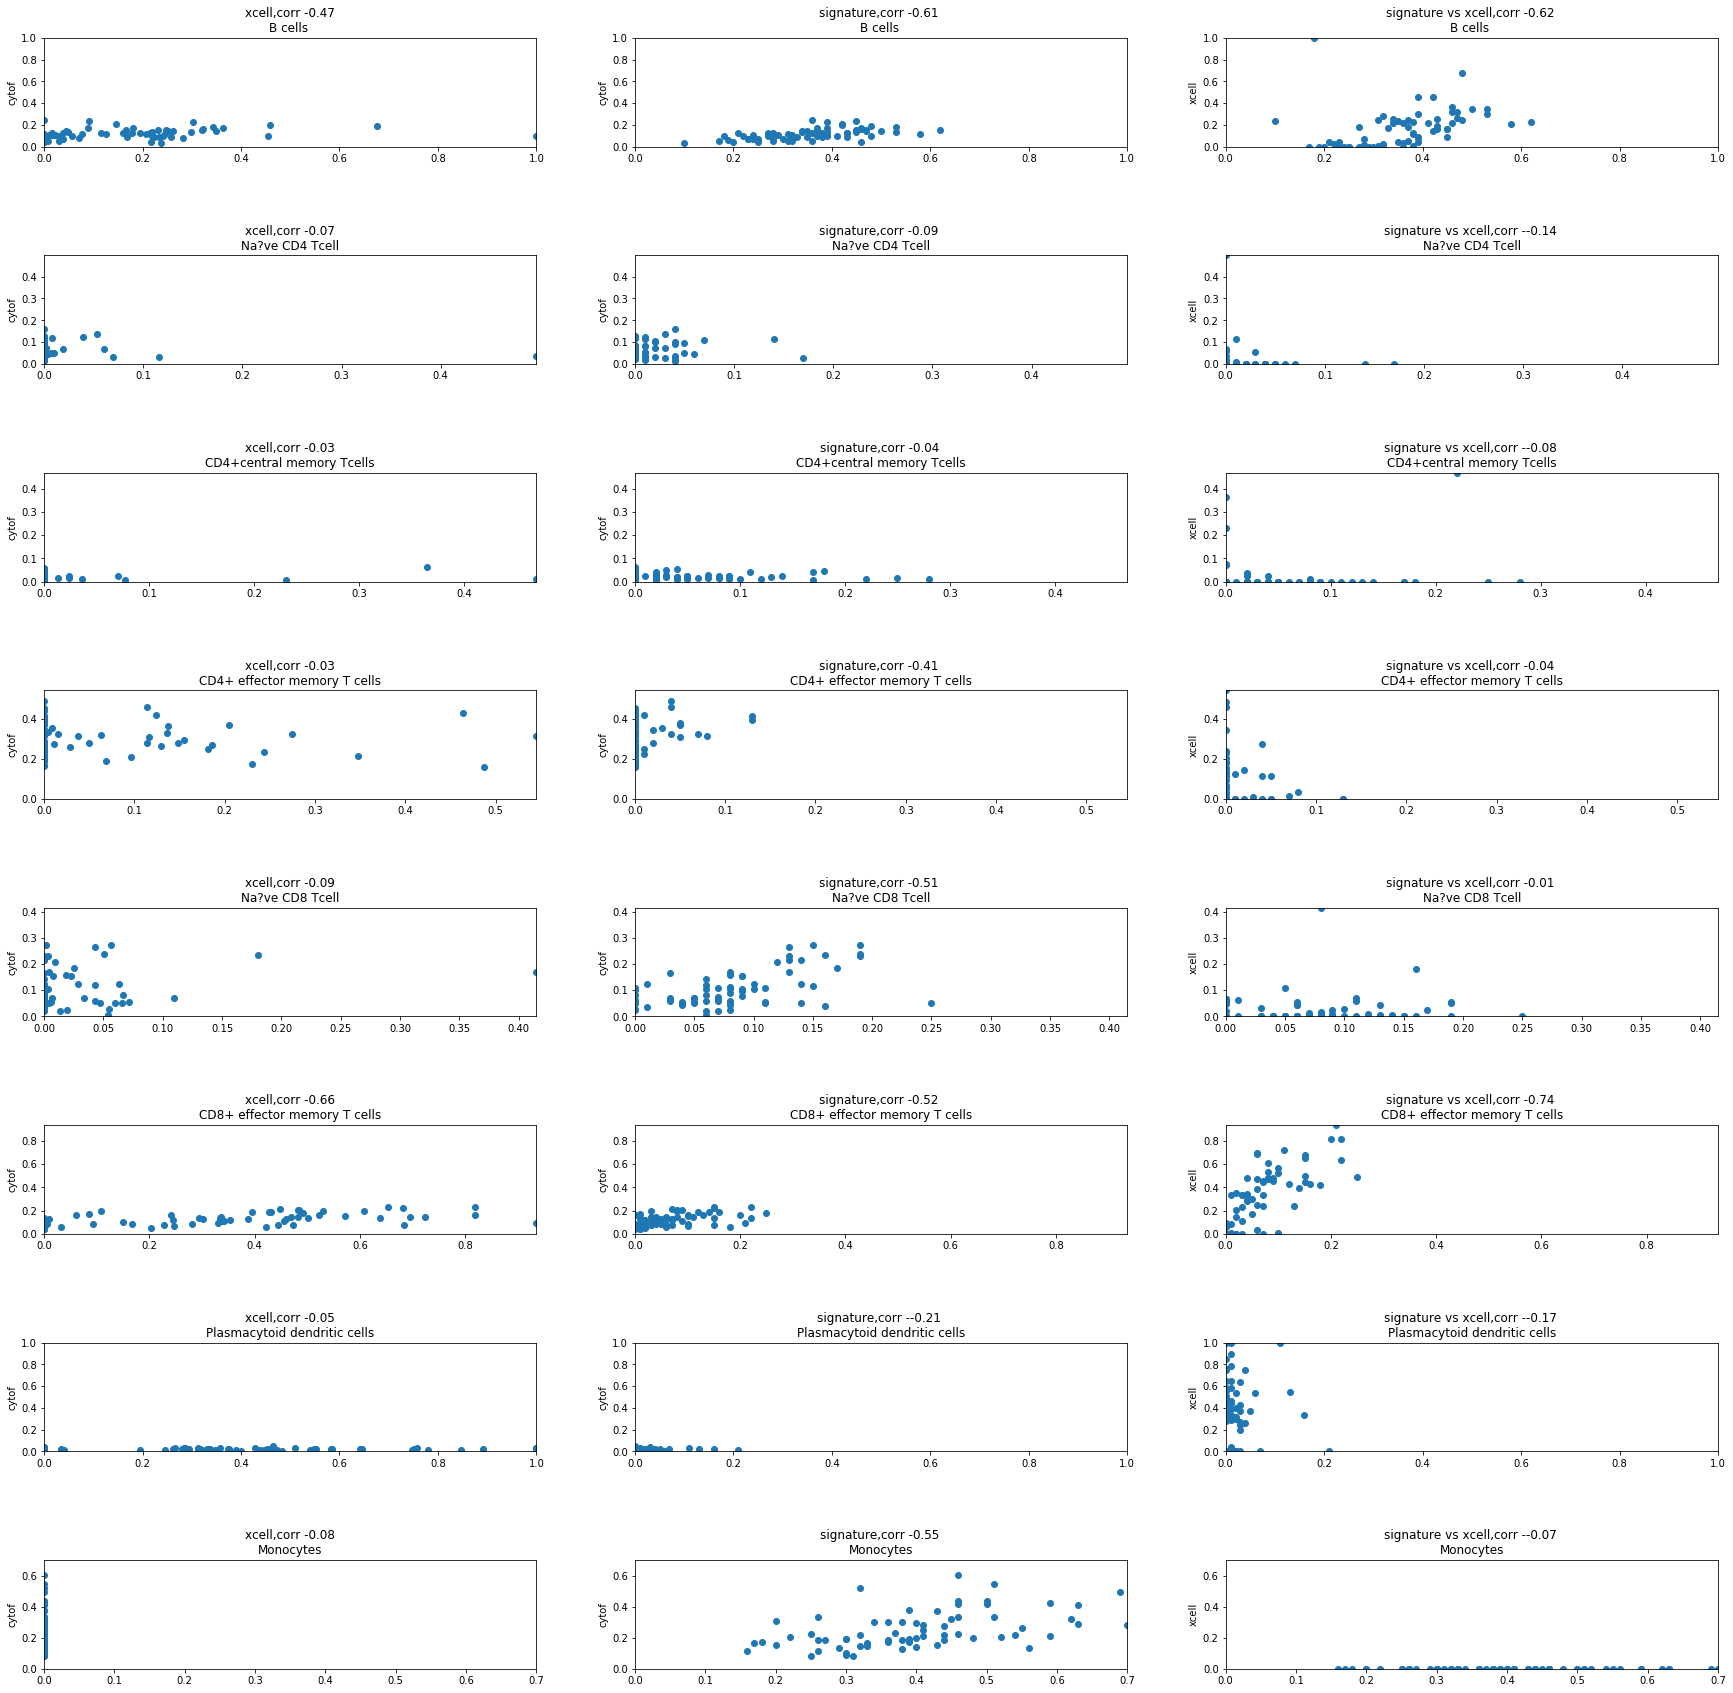

In [28]:
def compare_uuid_results_to_xcell(uuid,cytof_results,xcell_results,correlation_method="pearson"):
    _pipe = PipelineDeconv(hyper_configuration={},
                                     hyper_measure_configuration={})

    best_results_and_known = _pipe.load_results_from_archive(uuid)
    best_results=best_results_and_known["result"]
    best_known=cytof_results

    mix_mapping = GlobalUtils.get_corospanding_mixtures_map(best_known,best_results)

    res_as_cytof = xcell_results.rename(columns=mix_mapping)
    sample_over_cytof_count =best_known.rename(columns=mix_mapping)
    mass_results_not_none_df = best_results.rename(columns=mix_mapping)

    mutual_mixtures = res_as_cytof.columns.intersection(sample_over_cytof_count.columns.intersection(mass_results_not_none_df.columns))
    res_as_cytof = res_as_cytof[mutual_mixtures]
    sample_over_cytof_count = sample_over_cytof_count[mutual_mixtures]
    mass_results_not_none_df = mass_results_not_none_df[mutual_mixtures]

    res_as_cytof_for_corr = res_as_cytof.copy(deep=True)
    sample_over_cytof_count = sample_over_cytof_count
    
    cytof_plots.plot_mass_to_cytof_scatter_all_on_one(res_as_cytof,sample_over_cytof_count,mass_results_not_none_df)

    try:
        res_as_cytof_for_corr = res_as_cytof.copy(deep=True).drop(["Unknown"])  # 24_v1
        sample_over_cytof_count = sample_over_cytof_count.rename(
            columns={col: f"{col.split('-')[1]}_v{col.split('V')[1]}" for col in sample_over_cytof_count.columns})
    except:
        pass

    mass_results_not_none_over_sample = mass_results_not_none_df[sample_over_cytof_count.columns]

    propgated_scatter_results = {cell: pd.DataFrame(index=mutual_mixtures, columns=["deconv", "cytof"], data=0.0) for
                                 cell in res_as_cytof.index}
    
    not_propgated_scatter_results = {cell: pd.DataFrame(index=mutual_mixtures, columns=["deconv", "cytof"], data=0.0)
                                     for cell in res_as_cytof.index}
  
    for mixture in mutual_mixtures:
        for cell, x_cytof in res_as_cytof_for_corr[mixture].iteritems():
            x_not_none_in_cytof = mass_results_not_none_over_sample[mixture].loc[cell]
            y = sample_over_cytof_count[mixture].loc[cell]

            propgated_scatter_results[cell]["deconv"].loc[mixture] = x_cytof
            propgated_scatter_results[cell]["cytof"].loc[mixture] = y

            not_propgated_scatter_results[cell]["deconv"].loc[mixture] = x_not_none_in_cytof
            not_propgated_scatter_results[cell]["cytof"].loc[mixture] = y

    fig, axs = plt.subplots(8, 3, figsize=(30, 30))
    for i, _cell in enumerate(propgated_scatter_results.keys()):
        axs[i, 0].scatter(propgated_scatter_results[_cell]["deconv"], propgated_scatter_results[_cell]["cytof"],
                          label=_cell)
        axs[i, 1].scatter(not_propgated_scatter_results[_cell]["deconv"], not_propgated_scatter_results[_cell]["cytof"],
                          label=_cell)
        axs[i, 2].scatter(not_propgated_scatter_results[_cell]["deconv"], propgated_scatter_results[_cell]["deconv"],
                          label=_cell)
        
        max_known = propgated_scatter_results[_cell]["cytof"].max()
        max_deconv_prop = propgated_scatter_results[_cell]["deconv"].max()
        max_deconv_not_prop = not_propgated_scatter_results[_cell]["deconv"].max()
        
        _limit = max(max_known,max_deconv_prop,max_deconv_not_prop)

        axs[i, 0].set_xlim(left=0, right=_limit)
        axs[i, 1].set_xlim(left=0, right=_limit)
        axs[i, 2].set_xlim(left=0, right=_limit)

        axs[i, 0].set_ylim(bottom=0, top=_limit)
        axs[i, 1].set_ylim(bottom=0, top=_limit)
        axs[i, 2].set_ylim(bottom=0, top=_limit)

        axs[i, 0].set_ylabel("cytof")
        axs[i, 1].set_ylabel("cytof")
        axs[i, 2].set_ylabel("xcell")

        if i == 8:
            axs[i, 0].set_xlabel("Deconv")
            axs[i, 1].set_xlabel("Deconv")
            axs[i, 2].set_xlabel("Deconv")

#         axs[i, 0].legend()
#         axs[i, 1].legend()
#         axs[i, 2].legend()

        prop_corr = np.round(propgated_scatter_results[_cell]["deconv"].corr(propgated_scatter_results[_cell]["cytof"],method=correlation_method),2)
        not_prop_corr = np.round(
            not_propgated_scatter_results[_cell]["deconv"].corr(not_propgated_scatter_results[_cell]["cytof"],method=correlation_method), 2)
        sig_xcell_conv = np.round(propgated_scatter_results[_cell]["deconv"].corr(not_propgated_scatter_results[_cell]["deconv"],method=correlation_method),2)

        if i == 0:
            axs[i, 0].set_title(f"xcell,corr -{prop_corr}\n"+_cell)
            axs[i, 1].set_title(f"signature,corr -{not_prop_corr} \n"+_cell)
            axs[i, 2].set_title(f"signature vs xcell,corr -{sig_xcell_conv} \n"+_cell)
        else:
            axs[i, 0].set_title(f"xcell,corr -{prop_corr}\n"+_cell)
            axs[i, 1].set_title(f"signature,corr -{not_prop_corr} \n"+_cell)
            axs[i, 2].set_title(f"signature vs xcell,corr -{sig_xcell_conv} \n"+_cell)

    plt.subplots_adjust(hspace=1)
    plt.savefig(f"xcell_signature_for_shai{uuid}{correlation_method}")
    plt.show()
#     plt.savefig(f"xcell_signature_for_shai{uuid}")

compare_uuid_results_to_xcell("1773278244",cytof_results,results,"spearman")